Step 1: Mount drive and load images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
from PIL import Image
import numpy as np

folder_path = '/content/drive/MyDrive/Datasets_Assessment/Datasets/Raw_Images/'

# List all .tif and .tiff files
tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.tiff'))]
print(f"Total .tif images found: {len(tif_files)}")

images = {}
for filepath in tif_files:
    img = Image.open(filepath)
    img_array = np.array(img)
    images[os.path.basename(filepath)] = img_array

print(f"Loaded {len(images)} images.")

Mounted at /content/drive
Total .tif images found: 35
Loaded 35 images.


Step 2: Normalizing and extracting random patches

Total patches extracted from all images: 175


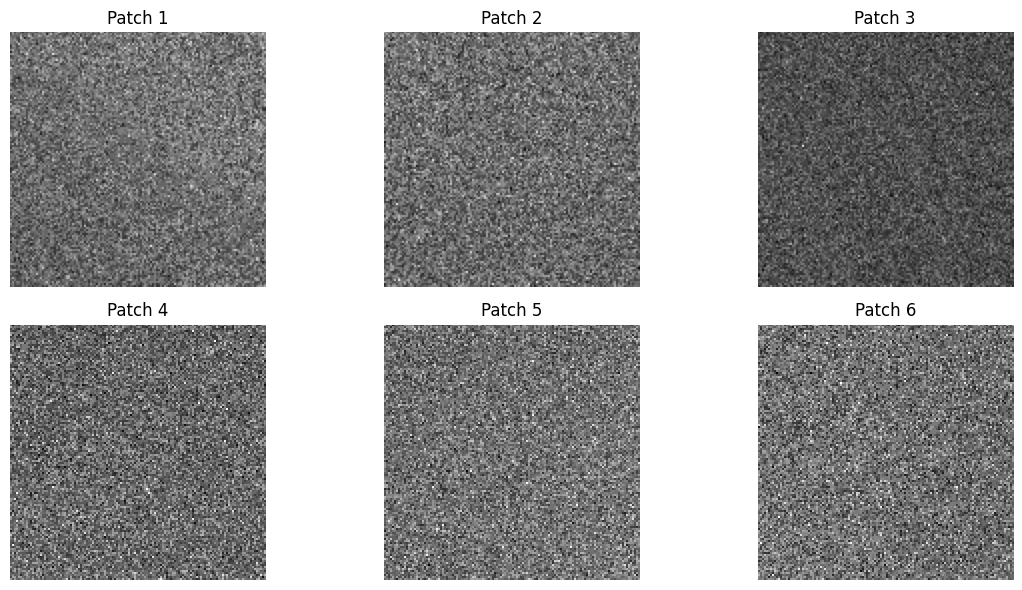

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image):
    return image / 65535.0  # normalize 16-bit to [0,1]

def extract_random_patches(image, patch_size=128, num_patches=5):
    patches = []
    coords = []

    height, width = image.shape
    for _ in range(num_patches):
        x = np.random.randint(0, width - patch_size)
        y = np.random.randint(0, height - patch_size)

        patch = image[y:y+patch_size, x:x+patch_size]
        patches.append(patch)
        coords.append((x, y))

    return patches, coords

# Extract patches from all images, but fewer patches per image
patches = []
coords = []

for img_array in images.values():
    norm_img = normalize_image(img_array)
    img_patches, img_coords = extract_random_patches(norm_img, patch_size=128, num_patches=5)
    patches.extend(img_patches)
    coords.extend(img_coords)

print(f"Total patches extracted from all images: {len(patches)}")

# Now randomly sample 100 patches if more than 100
if len(patches) > 100:
    indices = np.random.choice(len(patches), 100, replace=False)
    patches_sampled = [patches[i] for i in indices]
else:
    patches_sampled = patches

# Visualize some patches to confirm
num_to_show = min(6, len(patches_sampled))
plt.figure(figsize=(12, 6))
for i in range(num_to_show):
    plt.subplot(2, 3, i+1)
    plt.imshow(patches_sampled[i], cmap='gray')
    plt.title(f'Patch {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Step 3: Manually labeling patches using widgets

In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output

labels = []
index = 0

dropdown = widgets.Dropdown(options=[('Star', 0), ('Streak', 1), ('Noise/Empty', 2)], description='Label:')
button = widgets.Button(description='Submit')
output = widgets.Output()

def on_button_click(b):
    global index
    labels.append(dropdown.value)
    with output:
        clear_output(wait=True)
        index += 1
        if index < len(patches_sampled):
            plt.figure(figsize=(3,3))
            plt.imshow(patches_sampled[index], cmap='gray')
            plt.title(f'Patch {index+1}')
            plt.axis('off')
            plt.show()
            display(dropdown, button)
        else:
            print("✅ All labels collected!")
            print(labels)

button.on_click(on_button_click)

with output:
    plt.figure(figsize=(3,3))
    plt.imshow(patches_sampled[0], cmap='gray')
    plt.title('Patch 1')
    plt.axis('off')
    plt.show()
    display(dropdown, button)

display(output)

Output()

Step 4: Data preparation for CNN

In [13]:
import numpy as np

X = np.array(patches_sampled)
X = X.reshape(-1, 128, 128, 1).astype('float32')  # CNN input shape

y = np.array(labels)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (100, 128, 128, 1), y shape: (100,)


Step 5: Model Definition and Compilation

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Step 6:  Train-Test Split and Model Training

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step - accuracy: 0.9375 - loss: 1.0914 - val_accuracy: 1.0000 - val_loss: 1.0138
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.9792 - loss: 0.9812 - val_accuracy: 1.0000 - val_loss: 0.7107
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step - accuracy: 0.9688 - loss: 0.6606 - val_accuracy: 1.0000 - val_loss: 0.2469
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.9688 - loss: 0.2735 - val_accuracy: 1.0000 - val_loss: 0.0233
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step - accuracy: 0.9792 - loss: 0.1533 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 846ms/step - accuracy: 0.9792 - loss: 0.1869 - val_accuracy: 1.0000 - val_loss: 1.9203e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9688 - loss: 0.2924 - val_accuracy: 1.0000 - val_loss: 1.6433e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.9688 - loss: 0.2797 - val_accuracy: 1.0000 - v

Step 7: Evaluation and Accuracy Reporting

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 1.0000 - loss: 0.0064
Test accuracy: 1.0


Step 8: Accuracy visualization

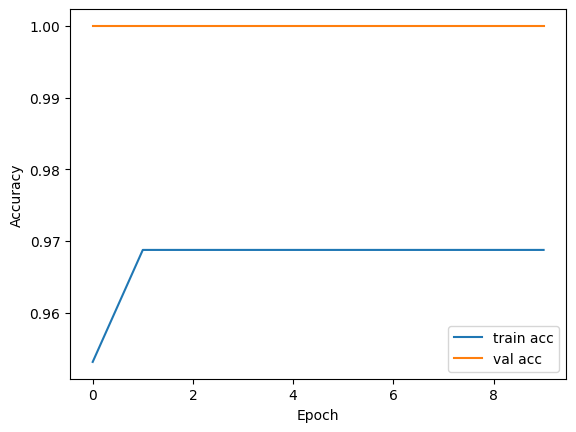

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Step 9: Save model

In [18]:
model.save('my_model.keras')

Step 10: Predicting labels on the test set

In [19]:
# Predict class probabilities
predictions = model.predict(X_test)

# Get predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Show a few predicted vs actual
print("Predicted labels:", predicted_labels[:10])
print("Actual labels:   ", y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Predicted labels: [2 2 2 2 2 2 2 2 2 2]
Actual labels:    [2 2 2 2 2 2 2 2 2 2]


OPTIONAL (Checking Predicted Class Distribution)

In [29]:
import numpy as np

unique, counts = np.unique(predicted_labels, return_counts=True)
print("Prediction Distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label} → Count: {count}")

X_test_gray = X_test.squeeze()  # Remove extra channel
centroid_results = find_centroids(X_test_gray, predicted_labels)

# View results
if len(centroid_results) == 0:
    print("No stars or streaks detected — only noise.")
else:
    for r in centroid_results[:10]:
        print(r)

Prediction Distribution:
Class 2 → Count: 20
No stars or streaks detected — only noise.


Further steps: when stars and streaks are detected correctly

In [27]:
from scipy.ndimage import label, center_of_mass
import numpy as np

def find_centroids(patches, labels, class_names=["star", "streak", "noise"]):
    results = []

    for i, (patch, label_id) in enumerate(zip(patches, labels)):
        if label_id == 2:  # Skip noise
            continue  # This 'continue' is valid because inside the 'for' loop

        threshold = np.percentile(patch, 99)
        binary = patch > threshold

        labeled_array, num_features = label(binary)
        if num_features == 0:
            continue  # Also inside the loop, this is valid

        centroids = center_of_mass(binary, labeled_array, range(1, num_features + 1))
        for c in centroids:
            results.append({
                'patch_index': i,
                'label': class_names[label_id],
                'centroid_y': c[0],
                'centroid_x': c[1]
            })

    return results

X_test_gray = X_test.squeeze()  # Remove channel dimension
centroid_results = find_centroids(X_test_gray, predicted_labels)

# Show first few centroids
for r in centroid_results[:10]:
    print(r)

# Optional: save to CSV
import pandas as pd
df = pd.DataFrame(centroid_results)
df.to_csv("centroid_results.csv", index=False)